In [1]:
import numpy as np
import pandas as pd
from shutil import copyfile
from astropy.cosmology import Planck13 as cosmo
from astropy.cosmology import z_at_value
import fsps
from matplotlib import gridspec
import matplotlib as mpl
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
import astropy.units as u
from sim_engine import Scale_model
from spec_tools import Source_present, Oldest_galaxy, Sig_int, Smooth, Rescale_sfh, lbt_to_z, boot_to_posterior, age_to_z, Posterior_spec
from spec_stats import Smooth, Highest_density_region, Linear_fit
from spec_id import *
from spec_stats import Highest_density_region, Linear_fit
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from sim_engine import forward_model_grism

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [2]:
morph_db = pd.read_pickle('../dataframes/fitdb/fullfitdb.pkl')

inout = []
for i in morph_db.index:
    for ii in range(len(morph_db.zgrism_hci[i])//2):
        if morph_db.zgrism_hci[i][2*ii] <= morph_db.zgrism[i] <= morph_db.zgrism_hci[i][2*ii+1]:
            if(morph_db.zgrism_hci[i][2*ii+1] - morph_db.zgrism_hci[i][2*ii]) /( 2 * (1 + morph_db.zgrism[i])) < 0.01:
                inout.append('i')
            else:
                inout.append('o')
        
morph_db['inout'] = inout
morph_db = morph_db.query('inout == "i" and n_f < 3 and Re < 20 and AGN == "-"')

mdb = morph_db.query('n_f < 3 and lmass >= 10.5')


In [5]:
def Get_mass_track(field, galaxy, lmass):
    lbt, sfh = np.load('../data/SFH/{}_{}.npy'.format(field, galaxy))    
    #make mass track
    mt = np.cumsum(sfh[::-1]) * (lbt[1] - lbt[0])*1E9
    
    #put into lookback time
    mt = np.array(mt)[::-1]
    
    #rescale
    mt /= max(mt)
    mt *= 10**lmass
    return lbt, mt

In [110]:
def Get_tq(field, galaxy):
    lbt, sfh = np.load('../data/SFH/{}_{}.npy'.format(field, galaxy))
    lbt, mtk = Get_mass_track(field, galaxy, mdb.query('id == {}'.format(galaxy)).lmass.values[0])
    
    sSFR = np.log10(sfh/mtk)
    
    prop_t = lbt + cosmo.lookback_time(mdb.query('id == {}'.format(galaxy)).zgrism.values[0]).value
    prop_a = (cosmo.hubble_time.value - prop_t) * 1E9
    
    sf_lim = np.log10(1/prop_a)
    q_lim = np.log10(0.2/prop_a)
    
    sf_frm = sSFR - sf_lim
    q_frm = sSFR - q_lim
    
    tq = interp1d(sf_frm, prop_t)(0) - interp1d(q_frm,prop_t)(0)
    th = interp1d(q_frm,prop_a)(0)
    
    return np.array([tq,th*1E-9])


In [111]:
tq,th = Get_tq('GND', 21156)

np.log10(tq/th)

In [86]:
field = 'GND'
galaxy = 21156

In [87]:
lbt, sfh = np.load('../data/SFH/{}_{}.npy'.format(field, galaxy))
lbt, mtk = Get_mass_track(field, galaxy, mdb.query('id == {}'.format(galaxy)).lmass.values[0])

In [88]:
prop_t = lbt + cosmo.lookback_time(mdb.query('id == {}'.format(galaxy)).zgrism.values[0]).value
prop_a = (cosmo.hubble_time.value - prop_t) * 1E9

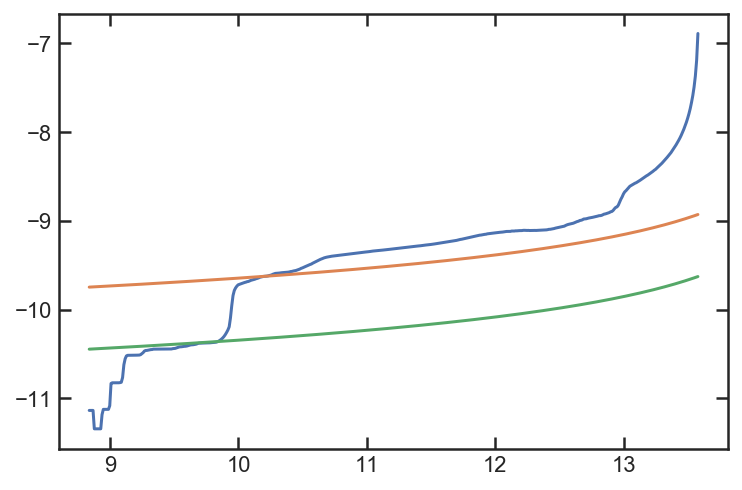

In [89]:
plt.plot(prop_t,np.log10(sfh/mtk))
# plt.xticks(cosmo.lookback_time([1.5,2,3,4,5,6,9]).value, [1.5,2,3,4,5,6,9] )
plt.plot(prop_t, np.log10(1/prop_a))
plt.plot(prop_t, np.log10(0.2/prop_a))
# plt.xlim(12,13)
# plt.ylim(-10.5, -9)
# plt.axvspan(12.395, 12.42, alpha = 0.2)
plt.minorticks_off()

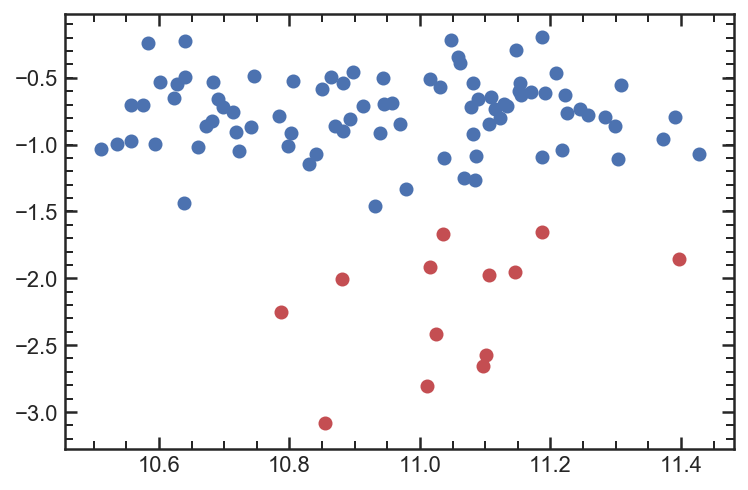

In [127]:
zlim = np.percentile(mdb.z_50,50)
Smdb = mdb.query('z_50 > {}'.format(zlim)).sort_values('Sigma1')

trk = []

for i in mdb.index:
    tq,th = Get_tq(mdb.field[i], mdb.id[i])
    if np.log10(tq/th) > -1.5:  
        plt.scatter(mdb.lmass[i] ,np.log10(tq/th),color = 'b')
#         plt.scatter(mdb.Re_f125[i] - mdb.Re_f160[i] ,np.log10(tq/th),color = 'b')
        
    if np.log10(tq/th) < -1.5:  
        plt.scatter(mdb.lmass[i] ,np.log10(tq/th),color = 'r')
#         plt.scatter(mdb.Re_f125[i] - mdb.Re_f160[i] ,np.log10(tq/th),color = 'r')
    trk.append(np.log10(tq/th))   
# plt.axhline(-1.5)

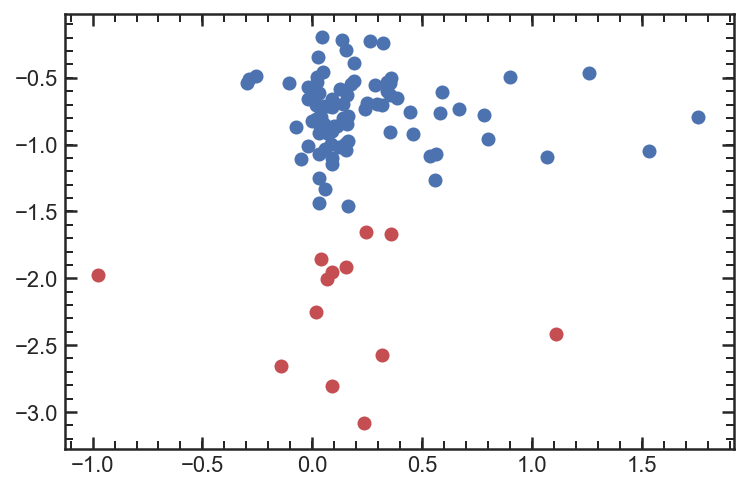

In [128]:
zlim = np.percentile(mdb.z_50,50)
Smdb = mdb.query('z_50 > {}'.format(zlim)).sort_values('Sigma1')

trk = []

for i in mdb.index:
    tq,th = Get_tq(mdb.field[i], mdb.id[i])
    if np.log10(tq/th) > -1.5:  
        plt.scatter(mdb.Re_f125[i] - mdb.Re_f160[i] ,np.log10(tq/th),color = 'b')
        
    if np.log10(tq/th) < -1.5:  
        plt.scatter(mdb.Re_f125[i] - mdb.Re_f160[i] ,np.log10(tq/th),color = 'r')
    trk.append(np.log10(tq/th))   
# plt.axhline(-1.5)

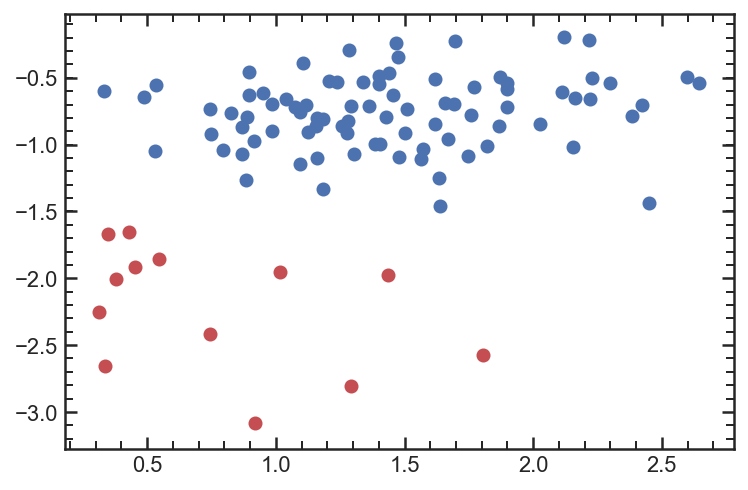

In [129]:
zlim = np.percentile(mdb.z_50,50)
Smdb = mdb.query('z_50 > {}'.format(zlim)).sort_values('Sigma1')

trk = []

for i in mdb.index:
    tq,th = Get_tq(mdb.field[i], mdb.id[i])
    if np.log10(tq/th) > -1.5:  
        plt.scatter(mdb.t_50[i] - mdb.t_90[i] ,np.log10(tq/th),color = 'b')
        
    if np.log10(tq/th) < -1.5:  
        plt.scatter(mdb.t_50[i] - mdb.t_90[i] ,np.log10(tq/th),color = 'r')
    trk.append(np.log10(tq/th)) 

(10.45, 9.4)

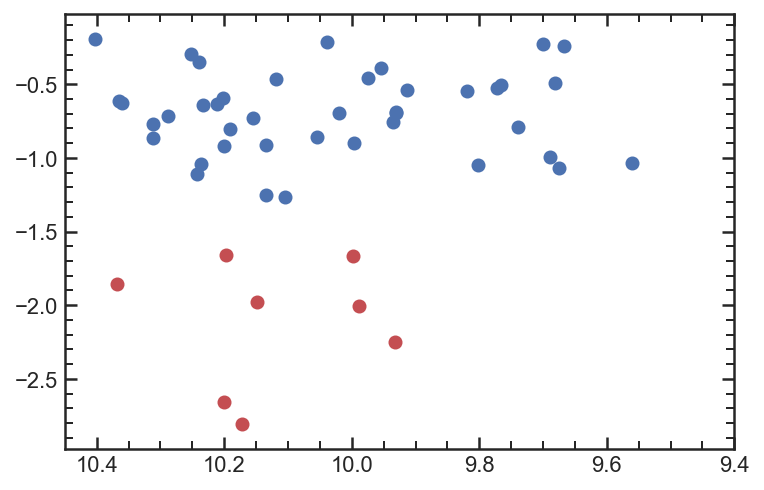

In [138]:
zlim = np.percentile(mdb.z_50,50)
Smdb = mdb.query('z_50 > {}'.format(zlim)).sort_values('Sigma1')

trk = []

for i in Smdb.index:
    tq,th = Get_tq(mdb.field[i], mdb.id[i])
    if np.log10(tq/th) > -1.5:  
        plt.scatter(np.log10(mdb.Sigma1[i]) ,np.log10(tq/th),color = 'b')
        
    if np.log10(tq/th) < -1.5:  
        plt.scatter(np.log10(mdb.Sigma1[i]) ,np.log10(tq/th),color = 'r')
    trk.append(np.log10(tq/th)) 
plt.xlim(10.45,9.4)

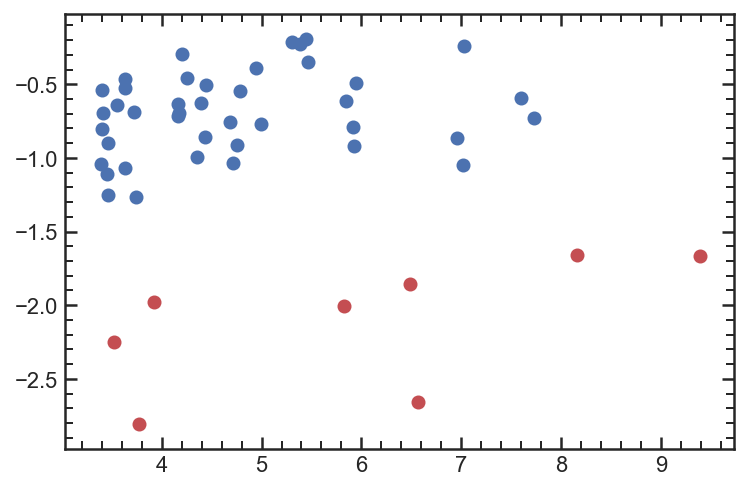

In [137]:
zlim = np.percentile(mdb.z_50,50)
Smdb = mdb.query('z_50 > {}'.format(zlim)).sort_values('Sigma1')

trk = []

for i in Smdb.index:
    tq,th = Get_tq(mdb.field[i], mdb.id[i])
    if np.log10(tq/th) > -1.5:  
        plt.scatter(mdb.z_50[i] ,np.log10(tq/th),color = 'b')
        
    if np.log10(tq/th) < -1.5:  
        plt.scatter(mdb.z_50[i] ,np.log10(tq/th),color = 'r')
    trk.append(np.log10(tq/th)) 
# plt.axvline(3.4)